# Ensemble Learning and Random Forests

# Voting Classiers

A very simple way to create an even better classifier is to aggregate the predictions of
each classifier and predict the class that gets the most votes. This majority-vote classi‐
fier is called a hard voting classifier

The following code creates and trains a voting classifier in Scikit-Learn, composed of
three diverse classifiers (the training set is the moons dataset, introduced in Chap‐
ter 5):

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [4]:
log_clf = LogisticRegression(solver='lbfgs')
rf_clf = RandomForestClassifier(n_estimators=100)
svm_clf = SVC(gamma='scale')

In [5]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [6]:
X, y = datasets.make_moons(n_samples=10000, noise=0.5)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [7]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((6700, 2), (6700,), (3300, 2), (3300,))

In [8]:
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rf_clf), ('svc', svm_clf)], voting='hard')

In [9]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [10]:
from sklearn.metrics import accuracy_score

In [11]:
for clf in [log_clf, rf_clf, svm_clf, voting_clf]:
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_hat))

LogisticRegression 0.8087878787878788
RandomForestClassifier 0.7996969696969697
SVC 0.8248484848484848
VotingClassifier 0.8209090909090909


There we have it! The voting classifier slightly outperforms the individual classifiers.

If all ensemble method learners can estimate class probabilities, we can average their probabilities per class then predict the class with the highest probability. This is called Soft voting. It often yields results better than hard voting because it weights confidence.

# Bagging and Pasting in Scikit-Learn


In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


bagging classifier is classifier which takes one type of classifier algorithm and uses different independent data for training that classifier 

The following code trains an
ensemble of 500 Decision Tree classifiers,5
each trained on 100 training instances ran‐
domly sampled from the training set with replacement (this is an example of bagging,
but if you want to use pasting instead, just set bootstrap=False). The n_jobs param‐
eter tells Scikit-Learn the number of CPU cores to use for training and predictions
(–1 tells Scikit-Learn to use all available cores)

In [14]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)

In [16]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1)

In [17]:
y_hat = bag_clf.predict(X_val)

In [18]:
y_hat

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

# Out-of-Bag Evaluation

With bagging, some instances will be sampled several times for several predictors, while others won't be sampled at all. Only about 63% of the instances are sampled for each predictor. The other 37% of instances not sampled are called Out-of-Bag (oob) instances. Note that they're not the same 37% for all predictors.

Since the individual predictor never sees the oob samples, it can be evaluated on the oob data without the need for a separate validation set.

We can evaluate the ensemble itself by averaging the oob scores of each predictor.

Let's do this using scikit-learn:

In [19]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=0.63, bootstrap=True, n_jobs=-1, oob_score=True)

In [20]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.63,
                  n_estimators=500, n_jobs=-1, oob_score=True)

In [21]:
bag_clf.oob_score_

0.8144776119402986

Let's verify this estimation using the validation set:

In [22]:
y_hat = bag_clf.predict(X_val)

In [23]:
accuracy_score(y_val, y_hat)

0.8033333333333333

Close enough!

The oob decision function is also available using scikit-learn's API, since our classifier is a decision tree then the decision function is a ratio that can be expressed as a probability, let's take a look at it for each instance:

In this case (since the base estimator has a pre
dict_proba() method) the decision function returns the class probabilities for each
training instance. For example, the oob evaluation estimates that the first training
instance has a 66.015625% probability of belonging to the positive class (and 33.984375% of
belonging to the negative class):


In [24]:
bag_clf.oob_decision_function_

array([[0.33984375, 0.66015625],
       [0.03984064, 0.96015936],
       [0.69201521, 0.30798479],
       ...,
       [0.27843137, 0.72156863],
       [0.98555957, 0.01444043],
       [0.84555985, 0.15444015]])

# Random Patches & Random Subspaces

We can sample features as well. Sampling is controlled by two hyper-parameters: max_features & bootstrap_features.

Each predictor will be trained on a random feature sample. This technique is especially useful when you're dealing with high-dimensional input as as imagery.

Sampling both instances and features is called "random patches" method. Sampling only features is called "random subspaces" method. Sampling features results in a more predictor diversity.

# Random Forests


As we have discussed, a Random Forest9
 is an ensemble of Decision Trees, generally
trained via the bagging method (or sometimes pasting), typically with max_samples
set to the size of the training set. Instead of building a BaggingClassifier and pass‐
ing it a DecisionTreeClassifier, you can instead use the RandomForestClassifier
class, which is more convenient and optimized for Decision Trees10 (similarly, there is
a RandomForestRegressor class for regression tasks). The following code trains a
Random Forest classifier with 500 trees (each limited to maximum 16 nodes), using
all available CPU cores

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

In [27]:
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1)

In [28]:
y_pred_rf = rnd_clf.predict(X_val)

The following BaggingClassifier is roughly equivalent to the previous RandomForestClassifier:

In [37]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

 the following code
trains a RandomForestClassifier on the iris dataset (introduced in Chapter 4) and
outputs each feature’s importance. It seems that the most important features are the
petal length (44%) and width (42%), while sepal length and width are rather unim‐
portant in comparison (11% and 2%, respectively).

In [44]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10697758146526572
sepal width (cm) 0.026112439944306842
petal length (cm) 0.4366034224960395
petal width (cm) 0.4303065560943879


# Let's plot pixel-wise MNIST feature importance:

In [31]:
from sklearn.datasets import load_digits
digits = load_digits()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(digits['data'], digits['target'])

RandomForestClassifier(n_estimators=500, n_jobs=-1)

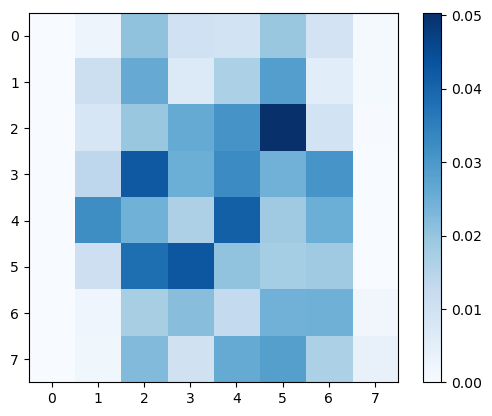

In [32]:
plt.imshow(rnd_clf.feature_importances_.reshape(8,8), cmap='Blues')
plt.colorbar()
plt.show()

In [ ]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)
